In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


#Imports

In [ ]:
# Core libraries
import os
import zipfile
import textwrap
from copy import deepcopy

# Data handling
import numpy as np
import pandas as pd
from tqdm import tqdm

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

# Machine learning - scikit-learn
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# Machine learning - other libraries
from xgboost import XGBClassifier

# Deep learning - TensorFlow/Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten, MaxPooling1D, SimpleRNN, Dropout
from tensorflow.keras.utils import to_categorical

# Scientific tools
from scipy.stats import pearsonr
from scipy.signal import find_peaks


#Load the dataset into a dataframe

In [ ]:
import os
import zipfile
import numpy as np
import pandas as pd
from tqdm import tqdm

def load_har_data(zip_path: str) -> pd.DataFrame:
    """
    Loads human activity recognition data from a zip file.
    Returns a DataFrame where each row is one participant–activity recording,
    with accelerometer/gyroscope numpy arrays and a duration (in minutes).
    """
    temp_extract_dir = "temp_har_data"
    os.makedirs(temp_extract_dir, exist_ok=True)

    # Unzip
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(temp_extract_dir)

    # Find root in case of extra parent folder
    items = os.listdir(temp_extract_dir)
    if len(items) == 1 and os.path.isdir(os.path.join(temp_extract_dir, items[0])):
        data_root = os.path.join(temp_extract_dir, items[0])
    else:
        data_root = temp_extract_dir

    activity_mapping = {
        'wlk': 'walk', 'idl': 'idle', 'ups': 'stairs_up',
        'dws': 'stairs_down', 'jog': 'running', 'cyc': 'cycling'
    }

    processed = []

    for part_folder in tqdm(os.listdir(data_root), desc="Participants"):
        part_path = os.path.join(data_root, part_folder)
        if not os.path.isdir(part_path) or not part_folder[:2].isdigit():
            continue
        pid = int(part_folder[:2])

        for act_folder in os.listdir(part_path):
            act_path = os.path.join(part_path, act_folder)
            code = act_folder[:3]
            if code not in activity_mapping or not os.path.isdir(act_path):
                continue

            accel_fp = os.path.join(act_path, 'Accelerometer.csv')
            gyro_fp  = os.path.join(act_path, 'Gyroscope.csv')
            if not (os.path.exists(accel_fp) and os.path.exists(gyro_fp)):
                continue

            # read CSVs
            accel_df = pd.read_csv(accel_fp)
            gyro_df  = pd.read_csv(gyro_fp)

            # extract arrays
            x_data = accel_df['x'].to_numpy()
            y_data = accel_df['y'].to_numpy()
            z_data = accel_df['z'].to_numpy()
            gx = gyro_df['x'].to_numpy()
            gy = gyro_df['y'].to_numpy()
            gz = gyro_df['z'].to_numpy()

            # resultants
            resultant_accel = np.sqrt(x_data**2 + y_data**2 + z_data**2)
            resultant_gyro  = np.sqrt(gx**2 + gy**2 + gz**2)

            # duration
            if 'seconds_elapsed' in accel_df.columns:
                duration_min = accel_df['seconds_elapsed'].iloc[-1] / 60.0
            else:
                # dynamic fallback to first column as timestamp
                ts_col = accel_df.columns[0]
                times = pd.to_datetime(accel_df[ts_col])
                delta = times.iloc[-1] - times.iloc[0]
                duration_min = delta.total_seconds() / 60.0

            processed.append({
                'pid': pid,
                'activity_name': activity_mapping[code],
                'x_data': x_data,
                'y_data': y_data,
                'z_data': z_data,
                'resultant_accelerometer': resultant_accel,
                'gyro_x': gx,
                'gyro_y': gy,
                'gyro_z': gz,
                'resultant_gyro': resultant_gyro,
                'duration_min': duration_min
            })

    if not processed:
        raise RuntimeError("No data processed — check your zip contents/structure.")
    return pd.DataFrame(processed)


In [ ]:
file_path = "drive/MyDrive/miniBTPData/datav4.zip"
activity_df = load_har_data(file_path)
activity_df
# activity_df[activity_df['activity_name'] == 'running'][['pid', 'duration_min']].value_counts()

Participants: 100%|██████████| 11/11 [00:03<00:00,  3.55it/s]


,pid,activity_name,x_data,y_data,z_data,resultant_accelerometer,gyro_x,gyro_y,gyro_z,resultant_gyro,duration_min
0,4,stairs_down,"[0.0088382959365844, 0.0542891919612884, 0.071...","[-0.1022427082061767, -0.1251404285430908, -0....","[-0.3340892791748047, -0.3354606628417969, -0....","[0.34949582732264006, 0.362134366684544, 0.320...","[0.675616979598999, 0.675616979598999, 0.67561...","[0.5955936312675476, 0.5955936312675476, 0.595...","[-0.0244346093386411, -0.0244346093386411, -0....","[0.9009923012226407, 0.9009923012226407, 0.900...",2.015188
1,4,walk,"[0.1370807886123657, 0.6722691059112549, 0.116...","[0.3473072052001953, 0.7071719169616699, 0.390...","[0.822260856628418, 1.0628795623779297, 0.9108...","[0.9030649775812692, 1.4428273753372787, 0.997...","[0.0018325957935303, 0.0018325957935303, 0.001...","[0.0684169083833694, 0.0684169083833694, 0.068...","[-0.0885754600167274, -0.0885754600167274, -0....","[0.11193678518367277, 0.11193678518367277, 0.1...",2.014699
2,4,idle,"[-0.0040840506553649, -0.1163400411605835, -0....","[0.0176978111267089, 0.0291359424591064, 0.055...","[0.0728883743286132, 0.1011486053466796, 0.132...","[0.075117288960001, 0.15689151883962676, 0.215...","[0.8051204085350037, 0.8051204085350037, 0.805...","[-0.4642575979232788, -0.4642575979232788, -0....","[-1.4049900770187378, -1.4049900770187378, -1....","[1.6845625859522653, 1.6845625859522653, 1.684...",5.176402
3,4,running,"[-0.5328254699707031, -0.6132419109344482, -0....","[0.5451021194458008, 0.2307958602905273, 0.290...","[1.735260009765625, 1.4045076370239258, 0.3518...","[1.8953011907255273, 1.549830336815069, 0.6937...","[0.8142833709716797, 0.8142833709716797, 0.814...","[-0.4862487316131592, -0.4862487316131592, -0....","[-0.5974262356758118, -0.5974262356758118, -0....","[1.1208984540582518, 1.1208984540582518, 1.120...",5.036658
4,4,stairs_up,"[-0.3489984273910522, 0.0036791563034057, 1.31...","[0.4972634315490722, 0.5480668544769287, -0.17...","[1.8226203918457031, 2.5211381912231445, 3.035...","[1.9212016852608607, 2.5800249208895734, 3.312...","[-0.0629191175103187, -0.0629191175103187, -0....","[0.0568104684352874, 0.0568104684352874, 0.056...","[0.3048217594623565, 0.3048217594623565, 0.304...","[0.31638986980281275, 0.31638986980281275, 0.3...",2.043031
...,...,...,...,...,...,...,...,...,...,...,...
107,6,idle,"[-0.0164482593536376, -0.0530326962471008, -0....","[-0.022978663444519, -0.0670143365859985, -0.0...","[-0.0771245956420898, -0.0934286117553711, -0....","[0.0821387086726889, 0.12661869401409345, 0.13...","[-0.0146484375, -0.0093231201171875, -0.002944...","[-0.0093994140625, 0.0023193359375, 0.00444030...","[0.0157470703125, 0.0295867919921875, 0.044509...","[0.023471172304266097, 0.03110752558946879, 0....",5.030256
108,6,idle,"[-0.0023247301578521, 0.0735045075416565, 0.06...","[0.3471488356590271, 0.3739403486251831, 0.347...","[-0.6872701644897461, -0.4913997650146484, -0....","[0.7699727251451753, 0.6218585257237506, 0.524...","[0.0819091796875, 0.012664794921875, -0.008636...","[-0.02105712890625, 0.0886688232421875, 0.1323...","[0.0570068359375, 0.0697784423828125, 0.068725...","[0.1019916454346072, 0.11354113028739377, 0.14...",5.046960
109,6,stairs_down,"[-0.0685709714889526, 0.3153436183929443, 0.57...","[-0.1503145098686218, 0.1174256205558776, 0.20...","[0.7913942337036133, 1.2188444137573242, 1.614...","[0.8084560984662754, 1.2644414098610988, 1.725...","[0.093719482421875, 0.097991943359375, 0.12461...","[-0.0928802490234375, -0.2079315185546875, -0....","[-0.3474884033203125, -0.4263153076171875, -0....","[0.3716964789800679, 0.48433736060781285, 0.65...",1.463527
110,6,stairs_up,"[0.7008916139602661, 0.7242263555526733, 0.786...","[0.3257783651351928, 0.4279247522354126, 0.542...","[0.501800537109375, 0.3610982894897461, 0.2592...","[0.9215120057564323, 0.9154318010235754, 0.990...","[0.0308685302734375, 0.0330047607421875, 0.018...","[-0.1781005859375, -0.153594970703125, -0.1408...","[0.7785034

###Displaying how much data we have

         Total Minutes of Sensor Data per Activity


,Total Minutes
activity_name,
walk,108.43
idle,72.90
cycling,64.18
running,32.94
stairs_up,28.82
stairs_down,24.82


/tmp/ipython-input-5-1316985807.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(




              Data Duration Visualization (Minutes)


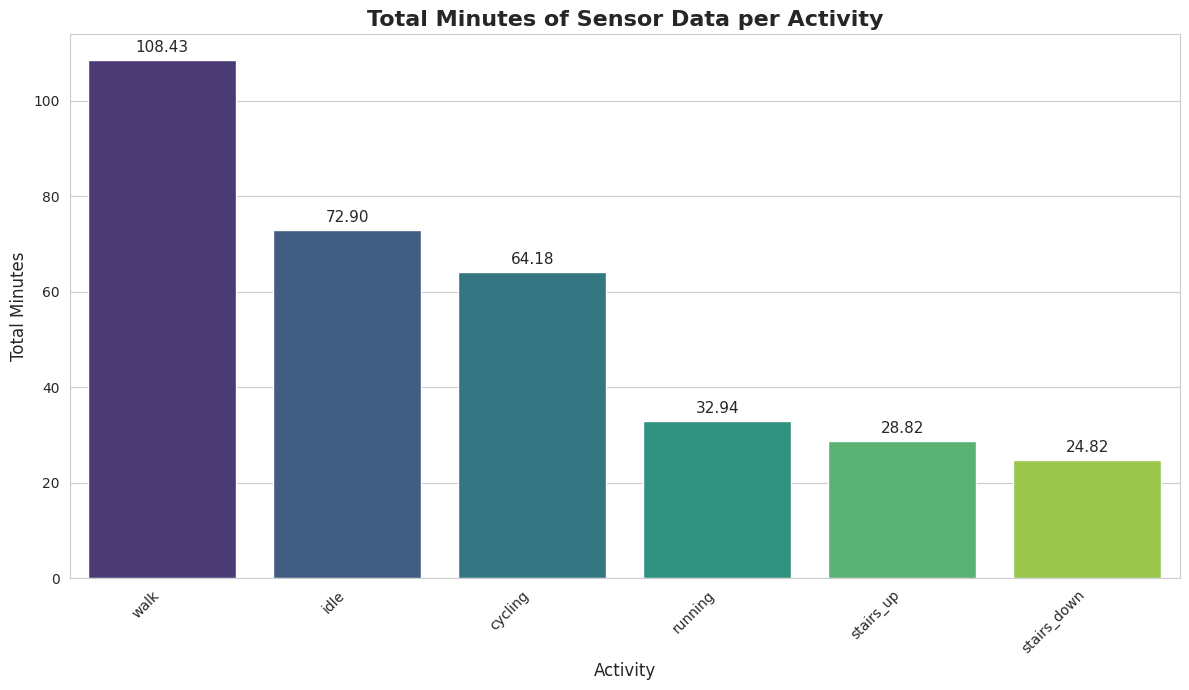

In [ ]:
# --- 1. Group and Sum Duration by Activity ---
minutes_per_activity = activity_df.groupby('activity_name')['duration_min'].sum().sort_values(ascending=False).round(2)

# --- 2. Display the Numerical Data ---
print("=" * 50)
print("         Total Minutes of Sensor Data per Activity")
print("=" * 50)
display(minutes_per_activity.to_frame(name='Total Minutes'))

# --- 3. Create the Visualization ---
print("\n\n" + "=" * 50)
print("              Data Duration Visualization (Minutes)")
print("=" * 50)

sns.set_style("whitegrid")
plt.figure(figsize=(12, 7))

barplot = sns.barplot(
    x=minutes_per_activity.index,
    y=minutes_per_activity.values,
    palette='viridis'
)

# Add data labels
for p in barplot.patches:
    barplot.annotate(f'{p.get_height():,.2f}',
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='center',
                     xytext=(0, 9),
                     textcoords='offset points',
                     fontsize=11)

plt.title('Total Minutes of Sensor Data per Activity', fontsize=16, fontweight='bold')
plt.xlabel('Activity', fontsize=12)
plt.ylabel('Total Minutes', fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


#Kalman Filter


In [ ]:
# --- 1. Kalman Filter Class for 1D Data ---
class KalmanFilter1D:
    def __init__(self, process_variance=1e-5, measurement_variance=0.01):
        self.x = 0.0  # initial estimate
        self.P = 1.0  # initial covariance
        self.Q = process_variance
        self.R = measurement_variance

    def update(self, measurement):
        self.P += self.Q
        K = self.P / (self.P + self.R)
        self.x += K * (measurement - self.x)
        self.P *= (1 - K)
        return self.x

# --- 2. Apply Kalman Filter to a 1D NumPy Array ---
def apply_kalman_filter_1d_array(data_array, process_var=1e-5, meas_var=0.01):
    kf = KalmanFilter1D(process_var, meas_var)
    return np.array([kf.update(z) for z in data_array])

# --- 3. Main Function: Apply to Full DataFrame ---
def apply_kalman_filter_to_har_dataframe(df, process_var=1e-5, meas_var=0.01):
    """
    Returns a new DataFrame where all sensor axes (accel + gyro + resultants) are filtered using Kalman filter.
    """
    df_filtered = deepcopy(df)  # preserve original

    # Define all sensor fields to filter
    columns_to_filter = [
        'x_data', 'y_data', 'z_data', 'resultant_accelerometer',
        'gyro_x', 'gyro_y', 'gyro_z', 'resultant_gyro'
    ]

    for col in columns_to_filter:
        df_filtered[col] = df_filtered[col].apply(
            lambda arr: apply_kalman_filter_1d_array(arr, process_var, meas_var)
        )

    return df_filtered


Applying the kalman filter to create a new datafram(with filtered data).

In [ ]:
filtered_df = apply_kalman_filter_to_har_dataframe(activity_df)

# Optional: confirm visually or numerically
print("Original sample (x_data):", activity_df['x_data'].iloc[0][:5])
print("Filtered sample (x_data):", filtered_df['x_data'].iloc[0][:5])

Original sample (x_data): [0.0088383  0.05428919 0.07173918 0.04854334 0.006451  ]
Filtered sample (x_data): [0.00875079 0.0314182  0.04483638 0.04576406 0.03786994]


Visualizing the change in filtered vs unfiltered.

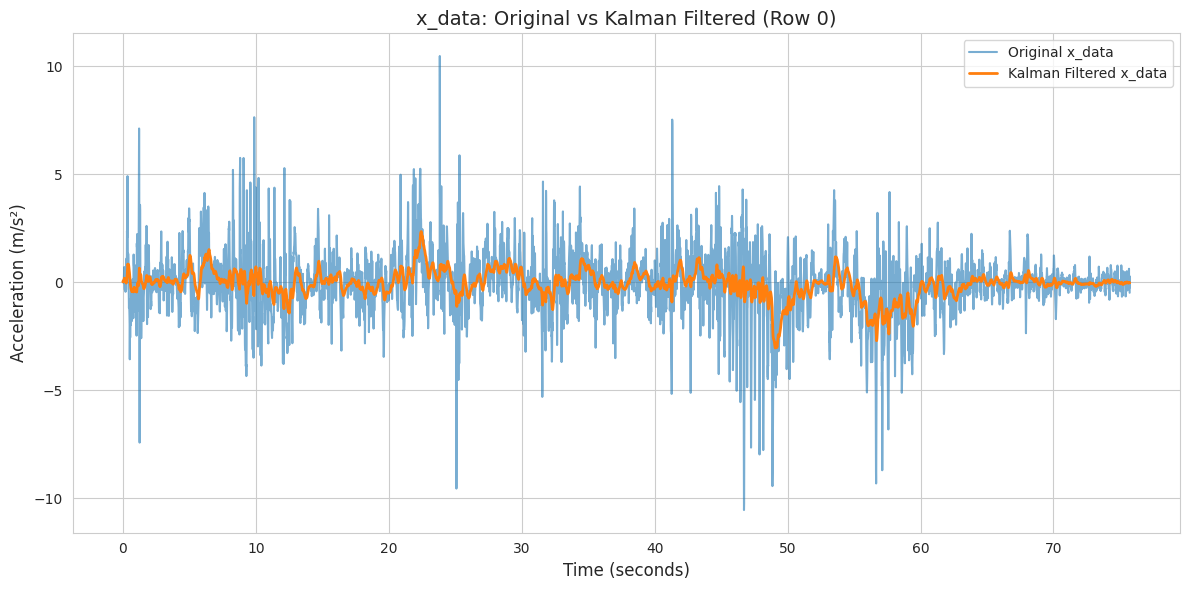

In [ ]:
def plot_filtered_vs_unfiltered(activity_df, filtered_df, row_index=0):
    """
    Plots original vs Kalman-filtered x_data for a given row in the DataFrame.
    Assumes both dataframes are aligned.
    """
    # Extract the raw and filtered data
    original_x = activity_df.iloc[row_index]['x_data']
    filtered_x = filtered_df.iloc[row_index]['x_data']

    # Create a time axis (assuming 100 Hz sampling rate)
    sampling_rate = 100  # Hz
    time_axis = np.arange(len(original_x)) / sampling_rate  # seconds

    # Plotting
    plt.figure(figsize=(12, 6))
    plt.plot(time_axis, original_x, label='Original x_data', alpha=0.6, linewidth=1.5)
    plt.plot(time_axis, filtered_x, label='Kalman Filtered x_data', linewidth=2)

    plt.title(f"x_data: Original vs Kalman Filtered (Row {row_index})", fontsize=14)
    plt.xlabel("Time (seconds)", fontsize=12)
    plt.ylabel("Acceleration (m/s²)", fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Example usage
plot_filtered_vs_unfiltered(activity_df, filtered_df, row_index=0)


##Extract features from both filtered and unfiltered data. Features are extracted for a fixed window and calculated sequentiall using a sliding window approach

In [ ]:
# --- Parameters ---
window_size = 128
overlap = 64

# --- Helpers ---
def create_windows(signal, window_size, overlap):
    step = window_size - overlap
    return [signal[i:i+window_size] for i in range(0, len(signal) - window_size + 1, step)]

def compute_apf(signal):
    peaks, _ = find_peaks(signal)
    return len(peaks)

def extract_signal_features(signal):
    return {
        'mean': np.mean(signal),
        'minmax': np.ptp(signal),
        'std': np.std(signal),
        'rms': np.sqrt(np.mean(np.square(signal))),
        'apf': compute_apf(signal)
    }

# --- Core feature extraction per row ---
def process_row(row):
    feature_rows = []

    try:
        # Extract signals
        x = row['x_data']
        y = row['y_data']
        z = row['z_data']
        mag = row['resultant_accelerometer']

        gx = row['gyro_x']
        gy = row['gyro_y']
        gz = row['gyro_z']
        gmag = row['resultant_gyro']

        activity = row['activity_name']
        assert isinstance(activity, str), f"Non-string activity label: {activity} ({type(activity)})"

        # Create windows
        x_windows = create_windows(x, window_size, overlap)
        y_windows = create_windows(y, window_size, overlap)
        z_windows = create_windows(z, window_size, overlap)
        m_windows = create_windows(mag, window_size, overlap)

        gx_windows = create_windows(gx, window_size, overlap)
        gy_windows = create_windows(gy, window_size, overlap)
        gz_windows = create_windows(gz, window_size, overlap)
        gm_windows = create_windows(gmag, window_size, overlap)

        n_windows = len(x_windows)
        if n_windows == 0 or not all(
            len(w) == n_windows for w in [
                y_windows, z_windows, m_windows,
                gx_windows, gy_windows, gz_windows, gm_windows
            ]
        ):
            return []

        for i in range(len(x_windows)):
            # Features
            xf = extract_signal_features(x_windows[i])
            yf = extract_signal_features(y_windows[i])
            zf = extract_signal_features(z_windows[i])
            mf = extract_signal_features(m_windows[i])

            gxf = extract_signal_features(gx_windows[i])
            gyf = extract_signal_features(gy_windows[i])
            gzf = extract_signal_features(gz_windows[i])
            gmf = extract_signal_features(gm_windows[i])

            # Cross-feature calculations
            var_apf = np.var([xf['apf'], yf['apf'], zf['apf']])
            gyro_var_apf = np.var([gxf['apf'], gyf['apf'], gzf['apf']])

            corr_xy = pearsonr(x_windows[i], y_windows[i])[0]
            corr_xz = pearsonr(x_windows[i], z_windows[i])[0]
            corr_yz = pearsonr(y_windows[i], z_windows[i])[0]
            corr_agx = pearsonr(x_windows[i], gx_windows[i])[0]
            corr_agy = pearsonr(y_windows[i], gy_windows[i])[0]
            corr_agz = pearsonr(z_windows[i], gz_windows[i])[0]

            feature_row = {
                'x_mean': xf['mean'], 'y_mean': yf['mean'], 'z_mean': zf['mean'], 'mag_mean': mf['mean'],
                'x_minmax': xf['minmax'], 'y_minmax': yf['minmax'], 'z_minmax': zf['minmax'], 'mag_minmax': mf['minmax'],
                'x_std': xf['std'], 'y_std': yf['std'], 'z_std': zf['std'], 'mag_std': mf['std'],
                'x_rms': xf['rms'], 'y_rms': yf['rms'], 'z_rms': zf['rms'], 'mag_rms': mf['rms'],
                'x_apf': xf['apf'], 'y_apf': yf['apf'], 'z_apf': zf['apf'],
                'var_apf': var_apf,
                'corr_xy': corr_xy, 'corr_xz': corr_xz, 'corr_yz': corr_yz,
                'gyro_x_mean': gxf['mean'], 'gyro_y_mean': gyf['mean'], 'gyro_z_mean': gzf['mean'], 'gyro_mag_mean': gmf['mean'],
                'gyro_x_std': gxf['std'], 'gyro_y_std': gyf['std'], 'gyro_z_std': gzf['std'], 'gyro_mag_std': gmf['std'],
                'gyro_x_apf': gxf['apf'], 'gyro_y_apf': gyf['apf'], 'gyro_z_apf': gzf['apf'], 'gyro_var_apf': gyro_var_apf,
                'acc_gyro_corr_x': corr_agx, 'acc_gyro_corr_y': corr_agy, 'acc_gyro_corr_z': corr_agz,
                'activity': str(activity)
            }

            feature_rows.append(feature_row)
    except Exception as e:
        print(f"Error processing row: {e}")

    return feature_rows

# --- Run on full DataFrame ---
def create_feature_df(df):
    all_features = []
    for _, row in tqdm(df.iterrows(), total=len(df), desc="Extracting Features"):
        all_features.extend(process_row(row))
    return pd.DataFrame(all_features)

# Example usage (apply to your loaded dataframes):
unfiltered_feature_df = create_feature_df(activity_df)
filtered_feature_df = create_feature_df(filtered_df)


Extracting Features: 100%|██████████| 112/112 [00:29<00:00,  3.83it/s]


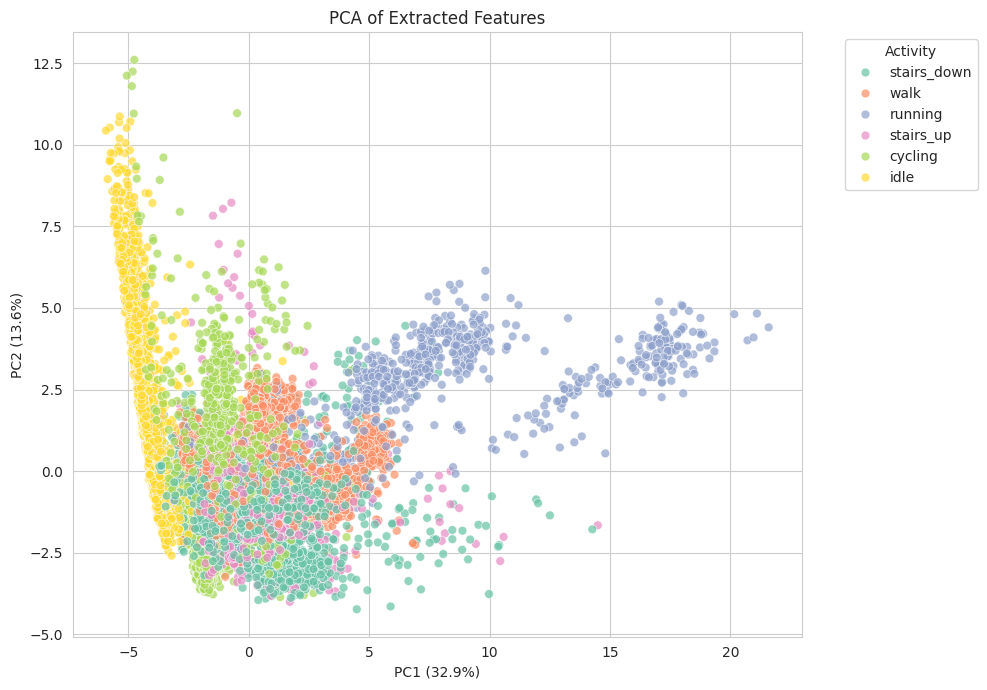

In [ ]:
# --- Step 1: Prepare Data ---
# Drop non-numeric and target column
features = filtered_feature_df.drop(columns=['activity'])
labels = filtered_feature_df['activity']

# Standardize the feature data (important for PCA)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

# --- Step 2: Apply PCA ---
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# --- Step 3: Visualize ---
plt.figure(figsize=(10, 7))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=labels, palette='Set2', s=40, alpha=0.7)
plt.title("PCA of Extracted Features")
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Activity')
plt.tight_layout()
plt.show()


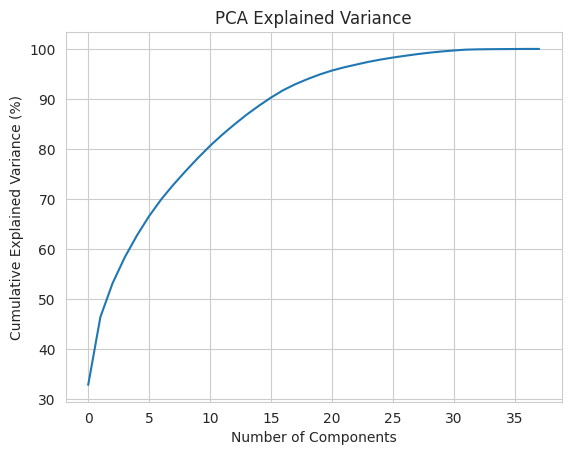

In [ ]:
pca_full = PCA().fit(X_scaled)
plt.plot(np.cumsum(pca_full.explained_variance_ratio_ * 100))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance (%)')
plt.title('PCA Explained Variance')
plt.grid(True)
plt.show()


In [ ]:
filtered_feature_df

,x_mean,y_mean,z_mean,mag_mean,x_minmax,y_minmax,z_minmax,mag_minmax,x_std,y_std,...,gyro_z_std,gyro_mag_std,gyro_x_apf,gyro_y_apf,gyro_z_apf,gyro_var_apf,acc_gyro_corr_x,acc_gyro_corr_y,acc_gyro_corr_z,activity
0,-0.014713,-0.180360,0.153273,2.092972,1.293147,1.178041,1.659324,3.779917,0.368333,0.211192,...,0.189020,0.211699,8,9,6,1.555556,-0.552510,-0.213971,-0.128290,stairs_down
1,-0.106595,-0.319203,0.501651,2.872161,1.105478,1.258119,1.889504,1.950360,0.264560,0.280960,...,0.078932,0.200311,9,10,8,0.666667,-0.545017,0.171650,-0.634851,stairs_down
2,0.033319,-0.178212,0.398506,2.524943,0.684230,1.258119,1.587550,2.876847,0.164417,0.308912,...,0.091100,0.258669,6,6,6,0.000000,-0.183389,0.309421,0.661185,stairs_down
3,0.061764,-0.090757,0.063886,1.806352,0.472432,0.542736,1.080070,2.086638,0.125583,0.139272,...,0.076246,0.134193,3,7,3,3.555556,0.096081,0.581775,0.095306,stairs_down
4,0.051329,-0.181681,0.216829,1.467532,0.472432,0.421322,1.080070,0.956166,0.110901,0.093884,...,0.082324,0.127319,7,11,6,4.666667,-0.205988,0.135578,0.457991,stairs_down
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11895,0.368023,-0.405240,0.122299,1.840153,0.772722,1.073414,0.979553,1.594503,0.244541,0.312254,...,0.114007,0.090208,5,6,6,0.222222,0.123235,-0.236096,-0.264803,stairs_down
11896,0.076378,-0.533833,0.181632,1.471659,1.182814,1.073414,0.953167,0.901406,0.318018,0.259366,...,0.234932,0.107965,4,4,3,0.222222,-0.164044,0.074450,-0.540369,stairs_down
11897,0.185860,-0.550025,0.180752,1.309265,1.349016,0.419677,0.646530,0.547301,0.397555,0.107750,...,0.363026,0.320181,3,3,2,0.222222,0.028192,-0.408908,0.387261,stairs_down
11898,0.417421,-0.666305,0.054686,1.498335,1.706856,1.054630,0.467407,0.850882,0.463795,0.292475,...,0.167399,0.132177,5,4,2,1.555556,0.588998,-0.805006,0.110209,stairs_down


In [ ]:
filtered_feature_df['activity'].value_counts()

,count
activity,
walk,3653
cycling,2287
idle,2239
stairs_down,1665
stairs_up,1130
running,926


In [ ]:
feature_cols = [
    'x_mean', 'y_mean', 'z_mean', 'mag_mean',
    'x_minmax', 'y_minmax', 'z_minmax', 'mag_minmax',
    'x_std', 'y_std', 'z_std', 'mag_std',
    'x_rms', 'y_rms', 'z_rms', 'mag_rms',
    'x_apf', 'y_apf', 'z_apf', 'var_apf',
    'corr_xy', 'corr_xz', 'corr_yz',
    'gyro_x_mean', 'gyro_y_mean', 'gyro_z_mean', 'gyro_mag_mean',
    'gyro_x_std', 'gyro_y_std', 'gyro_z_std', 'gyro_mag_std',
    'gyro_x_apf', 'gyro_y_apf', 'gyro_z_apf', 'gyro_var_apf',
    'acc_gyro_corr_x', 'acc_gyro_corr_y', 'acc_gyro_corr_z'
]

#Training traditional models and then evaluating it's performancing through 5-fold cross validation.

All evaluation results are stored in a dictionary called `results` while the trained models are stored in a dictionary called `trained_models`

Split the data. Train and test(80:20) and then 5-fold cross-validation is run on only the training split.

In [ ]:

# 1) Define your models
model_dict = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "SVM": SVC(),
    "KNN": KNeighborsClassifier(),
    "XGBoost": XGBClassifier(eval_metric='mlogloss')
}


# 2) Perform global standardization + train/test split for each dataset
def prepare_data_splits(df, feature_cols, label_col='activity'):
    X = df[feature_cols].values
    y = df[label_col].values
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    # we'll keep the scaler around if you want to inverse‐transform later:
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.2, stratify=y, random_state=42
    )
    return X_train, X_test, y_train, y_test, scaler

# Example usage:
X_unf_train, X_unf_test, y_unf_train, y_unf_test, scaler_unf = prepare_data_splits(unfiltered_feature_df, feature_cols)
X_flt_train, X_flt_test, y_flt_train, y_flt_test, scaler_flt = prepare_data_splits(filtered_feature_df, feature_cols)

In [ ]:
# 3) Training + evaluation on pre‐split data
def train_and_evaluate_from_splits(splits, model_names=None, n_splits=5):
    """
    splits: dict mapping 'unfiltered'/'filtered' -> (X_train, X_test, y_train, y_test, [optional]label_encoder)
    """
    if model_names is None:
        model_names = list(model_dict.keys())

    results = {}
    trained_models = {}

    for name in model_names:
        results[name] = {}

        for label, (X_train, X_test, y_train, y_test, le) in splits.items():
            # handle XGBoost label‐encoding
            if name == "XGBoost":
                y_train_enc = le.fit_transform(y_train)
                class_names = le.classes_
            else:
                y_train_enc = y_train
                class_names = np.unique(y_train)

            # 5‐fold CV on the TRAIN split
            skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
            model = model_dict[name]

            y_true_cv, y_pred_cv = [], []
            first_fold = True
            cm_y_true = cm_y_pred = None

            for train_idx, val_idx in skf.split(X_train, y_train_enc):
                X_tr, X_val = X_train[train_idx], X_train[val_idx]
                y_tr, y_val = y_train_enc[train_idx], y_train_enc[val_idx]
                model.fit(X_tr, y_tr)
                y_pi = model.predict(X_val)
                y_true_cv.extend(y_val)
                y_pred_cv.extend(y_pi)

                if first_fold:
                    cm_y_true = y_val
                    cm_y_pred = y_pi
                    first_fold = False

            # CV‐based report
            report = classification_report(
                y_true_cv, y_pred_cv, target_names=class_names, output_dict=True, zero_division=0
            )

            # Fit final model on ALL TRAIN data
            model.fit(X_train, y_train_enc)
            trained_models[(name, label)] = model

            results[name][label] = {
                'accuracy': report['accuracy'],
                'precision': report['weighted avg']['precision'],
                'recall': report['weighted avg']['recall'],
                'f1_score': report['weighted avg']['f1-score'],
                'report': report,
                'confusion_matrix': {
                    'y_test': cm_y_true,
                    'y_pred': cm_y_pred,
                    'labels': np.unique(y_train_enc),
                    'display_labels': class_names
                }
            }

    return results, trained_models


In [ ]:
# 4) Prepare the splits dict and run

splits = {
    'unfiltered': (X_unf_train, X_unf_test, y_unf_train, y_unf_test, LabelEncoder()),
    'filtered':   (X_flt_train, X_flt_test, y_flt_train, y_flt_test, LabelEncoder())
}

results, trained_models = train_and_evaluate_from_splits(splits, model_names=list(model_dict.keys()), n_splits=5)

In [ ]:
def plot_evaluation_results(results):
    for model_name, data in results.items():
        for label_type in ['unfiltered', 'filtered']:
            if label_type not in data:
                continue

            if 'confusion_matrix' not in data[label_type]:
                print(f"[WARN] Missing confusion matrix for {model_name} - {label_type}")
                continue

            cm_data = data[label_type]['confusion_matrix']
            y_test = cm_data['y_test']
            y_pred = cm_data['y_pred']
            labels = cm_data['labels']
            display_labels = cm_data['display_labels']

            # Plot confusion matrix
            disp = ConfusionMatrixDisplay.from_predictions(
                y_test,
                y_pred,
                labels=labels,
                display_labels=display_labels,
                cmap='Blues',
                xticks_rotation=45
            )

            # Title for the plot
            disp.ax_.set_title(f"{model_name} - {label_type.title()} Confusion Matrix")
            plt.tight_layout()
            plt.show()

            # Print classification report
            print(f"\n📋 Classification Report - {model_name} ({label_type.title()}):\n")
            print(classification_report(
                y_test,
                y_pred,
                target_names=display_labels,
                zero_division=0
            ))

    # Accuracy bar chart
    model_names = list(results.keys())
    acc_unfiltered = [results[m]['unfiltered']['accuracy'] for m in model_names]
    acc_filtered = [results[m]['filtered']['accuracy'] for m in model_names]

    x = np.arange(len(model_names))
    width = 0.35

    plt.figure(figsize=(10, 5))
    plt.bar(x - width/2, acc_unfiltered, width, label='Unfiltered')
    plt.bar(x + width/2, acc_filtered, width, label='Filtered')
    plt.xticks(x, [textwrap.fill(m, 15) for m in model_names], rotation=45)
    plt.ylabel('Accuracy')
    plt.title('Model Accuracy: Unfiltered vs Filtered')
    plt.ylim(0, 1)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

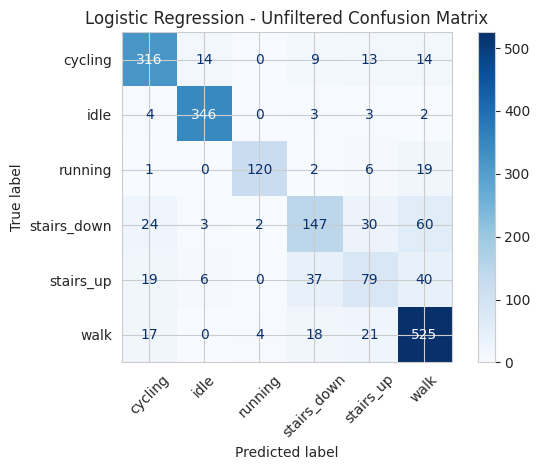


📋 Classification Report - Logistic Regression (Unfiltered):

              precision    recall  f1-score   support

     cycling       0.83      0.86      0.85       366
        idle       0.94      0.97      0.95       358
     running       0.95      0.81      0.88       148
 stairs_down       0.68      0.55      0.61       266
   stairs_up       0.52      0.44      0.47       181
        walk       0.80      0.90      0.84       585

    accuracy                           0.81      1904
   macro avg       0.79      0.75      0.77      1904
weighted avg       0.80      0.81      0.80      1904



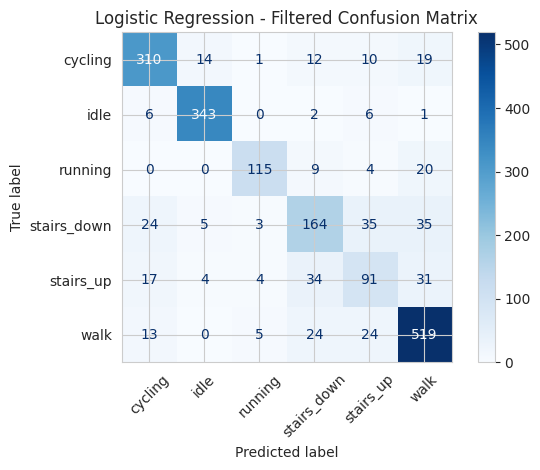


📋 Classification Report - Logistic Regression (Filtered):

              precision    recall  f1-score   support

     cycling       0.84      0.85      0.84       366
        idle       0.94      0.96      0.95       358
     running       0.90      0.78      0.83       148
 stairs_down       0.67      0.62      0.64       266
   stairs_up       0.54      0.50      0.52       181
        walk       0.83      0.89      0.86       585

    accuracy                           0.81      1904
   macro avg       0.78      0.76      0.77      1904
weighted avg       0.81      0.81      0.81      1904



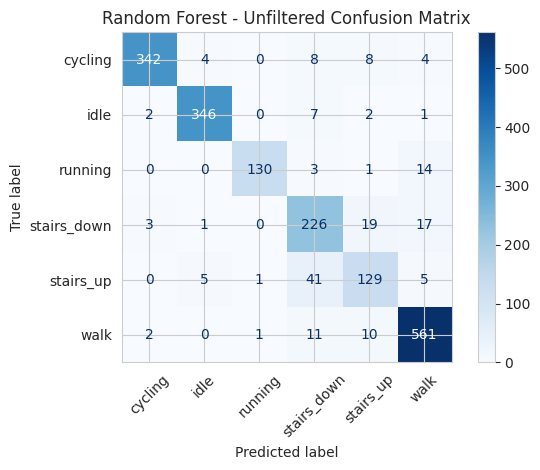


📋 Classification Report - Random Forest (Unfiltered):

              precision    recall  f1-score   support

     cycling       0.98      0.93      0.96       366
        idle       0.97      0.97      0.97       358
     running       0.98      0.88      0.93       148
 stairs_down       0.76      0.85      0.80       266
   stairs_up       0.76      0.71      0.74       181
        walk       0.93      0.96      0.95       585

    accuracy                           0.91      1904
   macro avg       0.90      0.88      0.89      1904
weighted avg       0.91      0.91      0.91      1904



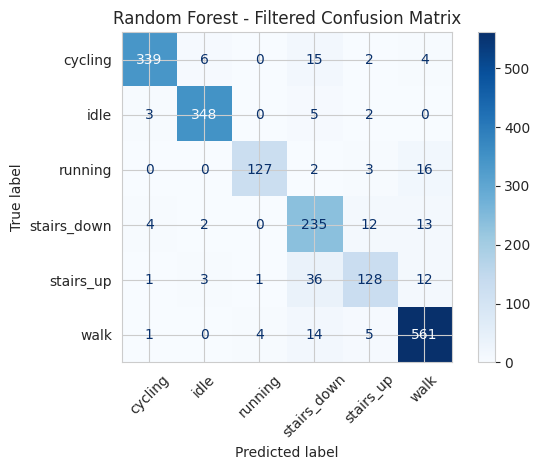


📋 Classification Report - Random Forest (Filtered):

              precision    recall  f1-score   support

     cycling       0.97      0.93      0.95       366
        idle       0.97      0.97      0.97       358
     running       0.96      0.86      0.91       148
 stairs_down       0.77      0.88      0.82       266
   stairs_up       0.84      0.71      0.77       181
        walk       0.93      0.96      0.94       585

    accuracy                           0.91      1904
   macro avg       0.91      0.88      0.89      1904
weighted avg       0.92      0.91      0.91      1904



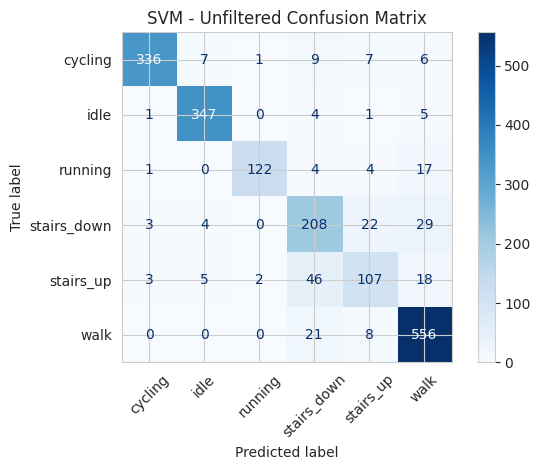


📋 Classification Report - SVM (Unfiltered):

              precision    recall  f1-score   support

     cycling       0.98      0.92      0.95       366
        idle       0.96      0.97      0.96       358
     running       0.98      0.82      0.89       148
 stairs_down       0.71      0.78      0.75       266
   stairs_up       0.72      0.59      0.65       181
        walk       0.88      0.95      0.91       585

    accuracy                           0.88      1904
   macro avg       0.87      0.84      0.85      1904
weighted avg       0.88      0.88      0.88      1904



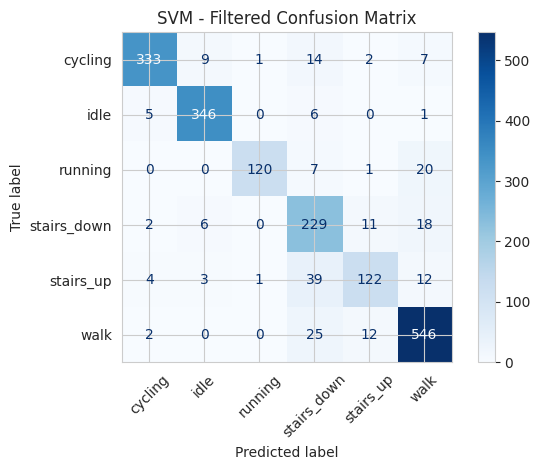


📋 Classification Report - SVM (Filtered):

              precision    recall  f1-score   support

     cycling       0.96      0.91      0.94       366
        idle       0.95      0.97      0.96       358
     running       0.98      0.81      0.89       148
 stairs_down       0.72      0.86      0.78       266
   stairs_up       0.82      0.67      0.74       181
        walk       0.90      0.93      0.92       585

    accuracy                           0.89      1904
   macro avg       0.89      0.86      0.87      1904
weighted avg       0.90      0.89      0.89      1904



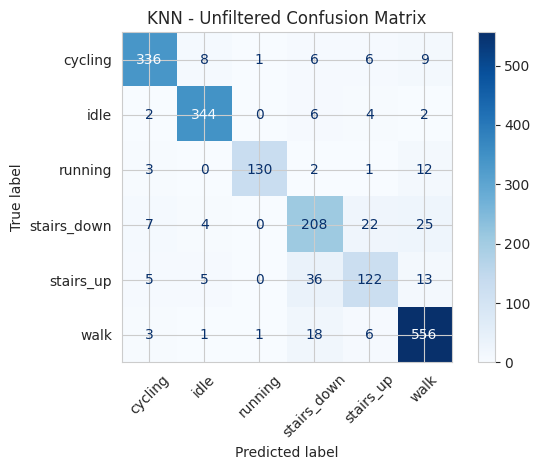


📋 Classification Report - KNN (Unfiltered):

              precision    recall  f1-score   support

     cycling       0.94      0.92      0.93       366
        idle       0.95      0.96      0.96       358
     running       0.98      0.88      0.93       148
 stairs_down       0.75      0.78      0.77       266
   stairs_up       0.76      0.67      0.71       181
        walk       0.90      0.95      0.93       585

    accuracy                           0.89      1904
   macro avg       0.88      0.86      0.87      1904
weighted avg       0.89      0.89      0.89      1904



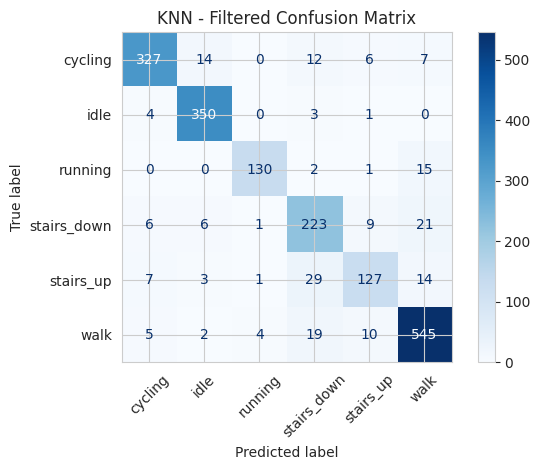


📋 Classification Report - KNN (Filtered):

              precision    recall  f1-score   support

     cycling       0.94      0.89      0.91       366
        idle       0.93      0.98      0.95       358
     running       0.96      0.88      0.92       148
 stairs_down       0.77      0.84      0.81       266
   stairs_up       0.82      0.70      0.76       181
        walk       0.91      0.93      0.92       585

    accuracy                           0.89      1904
   macro avg       0.89      0.87      0.88      1904
weighted avg       0.89      0.89      0.89      1904



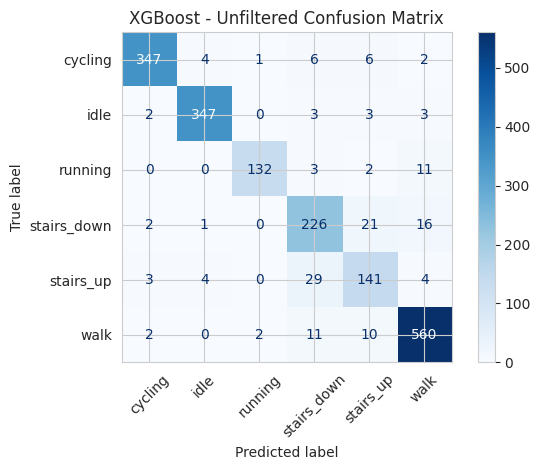


📋 Classification Report - XGBoost (Unfiltered):

              precision    recall  f1-score   support

     cycling       0.97      0.95      0.96       366
        idle       0.97      0.97      0.97       358
     running       0.98      0.89      0.93       148
 stairs_down       0.81      0.85      0.83       266
   stairs_up       0.77      0.78      0.77       181
        walk       0.94      0.96      0.95       585

    accuracy                           0.92      1904
   macro avg       0.91      0.90      0.90      1904
weighted avg       0.92      0.92      0.92      1904



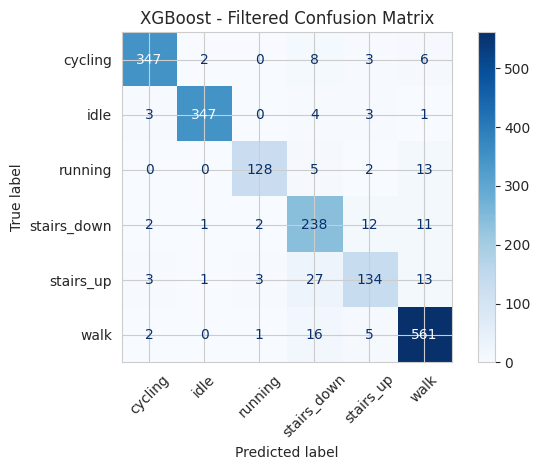


📋 Classification Report - XGBoost (Filtered):

              precision    recall  f1-score   support

     cycling       0.97      0.95      0.96       366
        idle       0.99      0.97      0.98       358
     running       0.96      0.86      0.91       148
 stairs_down       0.80      0.89      0.84       266
   stairs_up       0.84      0.74      0.79       181
        walk       0.93      0.96      0.94       585

    accuracy                           0.92      1904
   macro avg       0.91      0.90      0.90      1904
weighted avg       0.92      0.92      0.92      1904



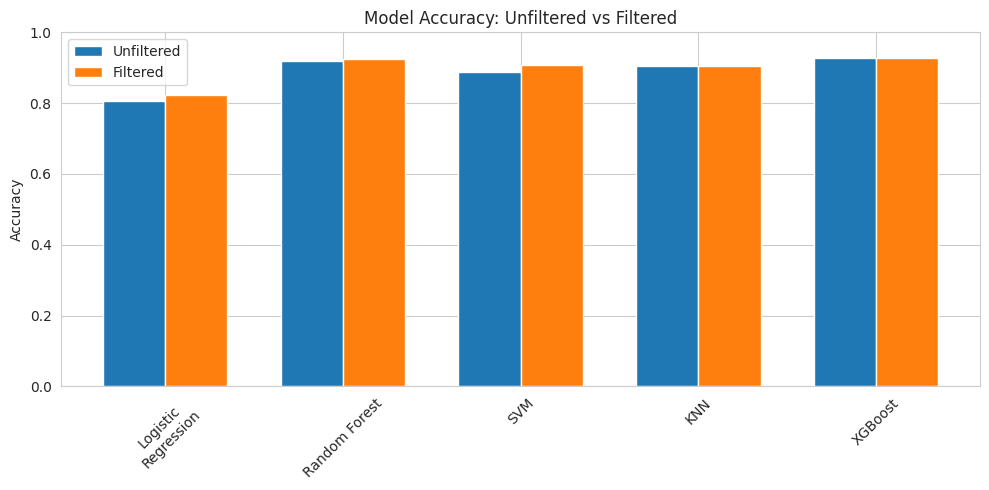

In [ ]:
plot_evaluation_results(results)

In [ ]:
def summarize_results(results):
    summary_data = []

    for model_name, model_results in results.items():
        row = {
            'Model': model_name
        }

        for data_type in ['unfiltered', 'filtered']:
            if data_type in model_results:
                report = model_results[data_type]['report']
                row[f'{data_type}_accuracy'] = report['accuracy']
                row[f'{data_type}_macro_f1'] = report['macro avg']['f1-score']
                row[f'{data_type}_weighted_f1'] = report['weighted avg']['f1-score']
            else:
                # In case some data is missing
                row[f'{data_type}_accuracy'] = None
                row[f'{data_type}_macro_f1'] = None
                row[f'{data_type}_weighted_f1'] = None

        summary_data.append(row)

    # Create and display the DataFrame
    summary_df = pd.DataFrame(summary_data)
    summary_df = summary_df.sort_values(by='filtered_accuracy', ascending=False)  # Optional: sort by best performance
    return summary_df

# Usage
summary_df = summarize_results(results)
summary_df

,Model,unfiltered_accuracy,unfiltered_macro_f1,unfiltered_weighted_f1,filtered_accuracy,filtered_macro_f1,filtered_weighted_f1
4,XGBoost,0.926155,0.910451,0.925938,0.927206,0.911853,0.927041
1,Random Forest,0.918803,0.902231,0.918636,0.924475,0.909244,0.924330
2,SVM,0.888971,0.866356,0.887908,0.906933,0.889544,0.906929
3,KNN,0.903676,0.885806,0.903144,0.904517,0.888902,0.904224
0,Logistic Regression,0.807248,0.772780,0.802864,0.823634,0.790562,0.821010


#XBBoost, Random Forest and SVM are the top performing models

#Checking the test accuracy of our best performing model xgboost

In [ ]:
def evaluate_xgboost_on_test_global():
    for dataset_type in ['unfiltered', 'filtered']:
        X_train, X_test, y_train, y_test, le = splits[dataset_type]

        # Fit label encoder if not already fitted
        if not hasattr(le, 'classes_'):
            le.fit(y_train)

        y_test_enc = le.transform(y_test)

        model = trained_models[("XGBoost", dataset_type)]
        y_pred = model.predict(X_test)

        print(f"\n=== XGBoost Evaluation on {dataset_type.capitalize()} Test Data ===")
        print(classification_report(y_test_enc, y_pred, target_names=le.classes_, zero_division=0))

# Run it
evaluate_xgboost_on_test_global()



=== XGBoost Evaluation on Unfiltered Test Data ===
              precision    recall  f1-score   support

     cycling       0.87      0.92      0.89       457
        idle       0.96      0.91      0.93       448
     running       0.64      0.92      0.75       185
 stairs_down       0.64      0.76      0.69       333
   stairs_up       0.69      0.43      0.53       226
        walk       0.86      0.78      0.82       731

    accuracy                           0.81      2380
   macro avg       0.78      0.79      0.77      2380
weighted avg       0.82      0.81      0.81      2380


=== XGBoost Evaluation on Filtered Test Data ===
              precision    recall  f1-score   support

     cycling       0.98      0.96      0.97       457
        idle       0.99      0.99      0.99       448
     running       0.96      0.92      0.94       185
 stairs_down       0.84      0.86      0.85       333
   stairs_up       0.84      0.81      0.82       226
        walk       0.94      0

##We can observe that the cross validation accuracy of xgboost on filtered and unfiltered data is about the same 93.7% and 93.9% (with unfiltered actually having a smidge more). However we see that the test accuracy on the unfiltered takes a good hit with it droping to only 83% signifying that the model overfitted to the noises in the unfiltered data, while the filtered data stayst strong with 94% test accuracy.  

#Hyperparameter tuning for XGBoost

In [ ]:

def tune_xgboost_with_cv(splits_dict, dataset_type='filtered'):
    # Unpack the split
    X_train, X_test, y_train, y_test, le = splits_dict[dataset_type]

    # Encode labels
    y_train_enc = le.fit_transform(y_train)
    y_test_enc = le.transform(y_test)

    # Define parameter grid
    param_grid = {
        'n_estimators': [50, 100, 150],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.8, 1.0]
    }

    xgb = XGBClassifier(eval_metric='mlogloss', use_label_encoder=False)

    # Set up grid search with 5-fold cross-validation
    grid_search = GridSearchCV(
        xgb,
        param_grid,
        scoring='accuracy',
        cv=5,
        verbose=1,
        n_jobs=-1
    )

    # Fit to training data
    grid_search.fit(X_train, y_train_enc)

    # Best model and parameters
    best_model = grid_search.best_estimator_
    print("Best Parameters:", grid_search.best_params_)

    # Evaluate on test data
    y_pred_test = best_model.predict(X_test)
    print("Test Classification Report:")
    print(classification_report(y_test_enc, y_pred_test, target_names=le.classes_))

    return best_model, grid_search.best_params_


In [ ]:
# Run tuning for filtered data
best_xgb_model_filtered, best_params_filtered = tune_xgboost_with_cv(splits, dataset_type='filtered')

# Run tuning for unfiltered data
# best_xgb_model_unfiltered, best_params_unfiltered = tune_xgboost_with_cv(splits, dataset_type='unfiltered')


Fitting 5 folds for each of 54 candidates, totalling 270 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:14:29] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best Parameters: {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 150, 'subsample': 0.8}
Test Classification Report:
              precision    recall  f1-score   support

     cycling       0.97      0.95      0.96       457
        idle       0.98      0.99      0.99       448
     running       0.94      0.94      0.94       185
 stairs_down       0.86      0.89      0.88       333
   stairs_up       0.86      0.82      0.84       226
        walk       0.94      0.95      0.95       731

    accuracy                           0.94      2380
   macro avg       0.93      0.92      0.92      2380
weighted avg       0.94      0.94      0.94      2380



##Performance of tuned model on test data


Classification Report (Filtered Test Set - Tuned XGBoost):
              precision    recall  f1-score   support

     cycling       0.97      0.95      0.96       457
        idle       0.98      0.99      0.99       448
     running       0.94      0.94      0.94       185
 stairs_down       0.86      0.89      0.88       333
   stairs_up       0.86      0.82      0.84       226
        walk       0.94      0.95      0.95       731

    accuracy                           0.94      2380
   macro avg       0.93      0.92      0.92      2380
weighted avg       0.94      0.94      0.94      2380



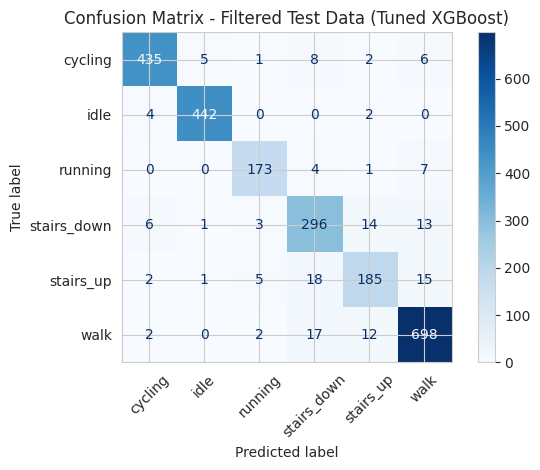

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Unpack the filtered split
X_train_flt, X_test_flt, y_train_flt, y_test_flt, le_flt = splits['filtered']

# Encode test labels using the same encoder used during training
y_test_enc_flt = le_flt.transform(y_test_flt)

# Predict on test set
y_pred_test_flt = best_xgb_model_filtered.predict(X_test_flt)

# Print classification report
print("Classification Report (Filtered Test Set - Tuned XGBoost):")
print(classification_report(y_test_enc_flt, y_pred_test_flt, target_names=le_flt.classes_))

# Optional: display confusion matrix
ConfusionMatrixDisplay.from_predictions(
    y_test_enc_flt,
    y_pred_test_flt,
    display_labels=le_flt.classes_,
    xticks_rotation=45,
    cmap='Blues'
)
plt.title("Confusion Matrix - Filtered Test Data (Tuned XGBoost)")
plt.tight_layout()
plt.show()


In [ ]:
# Step 1: Unpack the original filtered split (80/20)
X_flt_train_full, X_flt_test_full, y_flt_train_raw_full, y_flt_test_raw_full, le_flt = splits['filtered']

# Step 2: Encode labels
le_flt.fit(np.concatenate([y_flt_train_raw_full, y_flt_test_raw_full]))
y_flt_train_full = le_flt.transform(y_flt_train_raw_full)
y_flt_test_full = le_flt.transform(y_flt_test_raw_full)
class_names = le_flt.classes_

# Step 3: Split 20% into 10/10
X_val, X_test, y_val, y_test = train_test_split(
    X_flt_test_full, y_flt_test_full, test_size=0.5, stratify=y_flt_test_full, random_state=42
)

# Add new split to the `splits` dict
splits['filtered_80_10_10'] = (
    X_flt_train_full, X_val, X_test,
    y_flt_train_full, y_val, y_test,
    le_flt
)

#Training and evaluating deep learning models

In [ ]:
# Load the 80/10/10 split
X_train, X_val, X_test, y_train, y_val, y_test, le = splits['filtered_80_10_10']

# One-hot encode labels
num_classes = len(le.classes_)
y_train_cat = to_categorical(y_train, num_classes)
y_val_cat = to_categorical(y_val, num_classes)

# Dictionary to store models and results
dl_models = {}
dl_results = {}

# Common training parameters
epochs = 20
batch_size = 32
input_shape_flat = X_train.shape[1]
input_shape_seq = (X_train.shape[1], 1)

# ========== MLP ==========
mlp = Sequential([
    Dense(128, activation='relu', input_shape=(input_shape_flat,)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])
mlp.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
mlp.fit(X_train, y_train_cat, epochs=epochs, batch_size=batch_size, verbose=0, validation_data=(X_val, y_val_cat))
y_pred_mlp = np.argmax(mlp.predict(X_val), axis=1)
val_acc_mlp = np.mean(y_pred_mlp == y_val)
dl_models['MLP'] = mlp
dl_results['MLP'] = classification_report(y_val, y_pred_mlp, target_names=le.classes_, output_dict=True)
dl_results['MLP']['accuracy'] = val_acc_mlp

# ========== CNN ==========
X_train_cnn = X_train[..., np.newaxis]
X_val_cnn = X_val[..., np.newaxis]
cnn = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=input_shape_seq),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])
cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
cnn.fit(X_train_cnn, y_train_cat, epochs=epochs, batch_size=batch_size, verbose=0, validation_data=(X_val_cnn, y_val_cat))
y_pred_cnn = np.argmax(cnn.predict(X_val_cnn), axis=1)
val_acc_cnn = np.mean(y_pred_cnn == y_val)
dl_models['CNN'] = cnn
dl_results['CNN'] = classification_report(y_val, y_pred_cnn, target_names=le.classes_, output_dict=True)
dl_results['CNN']['accuracy'] = val_acc_cnn

# ========== RNN ==========
X_train_rnn = X_train[..., np.newaxis]
X_val_rnn = X_val[..., np.newaxis]
rnn = Sequential([
    SimpleRNN(64, input_shape=input_shape_seq),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])
rnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
rnn.fit(X_train_rnn, y_train_cat, epochs=epochs, batch_size=batch_size, verbose=0, validation_data=(X_val_rnn, y_val_cat))
y_pred_rnn = np.argmax(rnn.predict(X_val_rnn), axis=1)
val_acc_rnn = np.mean(y_pred_rnn == y_val)
dl_models['RNN'] = rnn
dl_results['RNN'] = classification_report(y_val, y_pred_rnn, target_names=le.classes_, output_dict=True)
dl_results['RNN']['accuracy'] = val_acc_rnn

# ========== Store in shared dicts ==========
for name in ['MLP', 'CNN', 'RNN']:
    trained_models[(name, "filtered_dl")] = dl_models[name]
    results[(name, "filtered_dl")] = dl_results[name]

# ========== Print summary ==========
from sklearn.metrics import classification_report
print("\n=== Validation Classification Reports ===")
print("\nMLP:\n", classification_report(y_val, y_pred_mlp, target_names=le.classes_))
print("\nCNN:\n", classification_report(y_val, y_pred_cnn, target_names=le.classes_))
print("\nRNN:\n", classification_report(y_val, y_pred_rnn, target_names=le.classes_))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step

=== Validation Classification Reports ===

MLP:
               precision    recall  f1-score   support

     cycling       0.97      0.93      0.95       228
        idle       0.95      1.00      0.97       224
     running       0.97      0.92      0.95        93
 stairs_down       0.79      0.88      0.83       166
   stairs_up       0.81      0.72      0.76       113
        walk       0.96      0.95      0.95       366

    accuracy                           0.92      1190
   macro avg       0.91      0.90      0.90      1190
weighted avg       0.92      0.92      0.92      1190


CNN:
               precision    recall  f1-score   support

     cycling       0.95      0.95      0.95       228
        idle       0.98      0.99      0.98       224
     running       0.96      0.94      0.95        93
 stairs_down       0.85      0.83      0.84       166
   stairs_up       0.78      0.77      0.78       113
        walk       0.94      0.96  

quite poor F1 averages for all deep learning models

##Evaluating Ensemble models(XGBoost + Random Forest + SVM)

Chose soft voting instead of something like stacking to combine the results of the different models to minimize the chances of overfitting since we're working with a dataset with limited diversity.

In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

# Step 4: Prepare base models
rf_model = trained_models[("Random Forest", "filtered")]
svm_model = trained_models[("SVM", "filtered")]
xgb_model = best_xgb_model_filtered

# Step 5: Define ensemble combinations
ensemble_combinations = {
    "RF + SVM": [("rf", rf_model), ("svm", svm_model)],
    "RF + XGB": [("rf", rf_model), ("xgb", xgb_model)],
    "SVM + XGB": [("svm", svm_model), ("xgb", xgb_model)],
    "RF + SVM + XGB": [("rf", rf_model), ("svm", svm_model), ("xgb", xgb_model)],
}

# Step 6: Train ensembles on 80%, validate on 10%
for name, estimators in ensemble_combinations.items():
    ensemble = VotingClassifier(estimators=estimators, voting='hard')
    ensemble.fit(X_flt_train_full, y_flt_train_full)

    # Predict on validation split
    y_val_pred = ensemble.predict(X_val)

    # Evaluation
    report = classification_report(
        y_val, y_val_pred, target_names=class_names, output_dict=True, zero_division=0
    )

    # Store model and results
    trained_models[(name, "filtered_ensemble")] = ensemble
    results[(name, "filtered_ensemble")] = report

    # Optional: Print summary
    print(f"\n=== Ensemble: {name} ===")
    print(classification_report(y_val, y_val_pred, target_names=class_names))



=== Ensemble: RF + SVM ===
              precision    recall  f1-score   support

     cycling       0.97      0.98      0.97       228
        idle       0.98      1.00      0.99       224
     running       0.96      0.92      0.94        93
 stairs_down       0.78      0.92      0.85       166
   stairs_up       0.88      0.72      0.79       113
        walk       0.97      0.94      0.95       366

    accuracy                           0.93      1190
   macro avg       0.92      0.91      0.92      1190
weighted avg       0.94      0.93      0.93      1190



/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:16:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



=== Ensemble: RF + XGB ===
              precision    recall  f1-score   support

     cycling       0.97      0.98      0.97       228
        idle       0.99      1.00      0.99       224
     running       0.94      0.95      0.94        93
 stairs_down       0.82      0.90      0.86       166
   stairs_up       0.87      0.74      0.80       113
        walk       0.96      0.95      0.95       366

    accuracy                           0.94      1190
   macro avg       0.92      0.92      0.92      1190
weighted avg       0.94      0.94      0.94      1190



/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:16:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



=== Ensemble: SVM + XGB ===
              precision    recall  f1-score   support

     cycling       0.96      0.97      0.97       228
        idle       0.99      1.00      0.99       224
     running       0.95      0.95      0.95        93
 stairs_down       0.81      0.90      0.85       166
   stairs_up       0.84      0.74      0.79       113
        walk       0.97      0.94      0.95       366

    accuracy                           0.93      1190
   macro avg       0.92      0.92      0.92      1190
weighted avg       0.93      0.93      0.93      1190



/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:16:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



=== Ensemble: RF + SVM + XGB ===
              precision    recall  f1-score   support

     cycling       0.98      0.96      0.97       228
        idle       0.99      1.00      0.99       224
     running       0.95      0.92      0.93        93
 stairs_down       0.84      0.90      0.87       166
   stairs_up       0.87      0.77      0.82       113
        walk       0.94      0.95      0.95       366

    accuracy                           0.94      1190
   macro avg       0.93      0.92      0.92      1190
weighted avg       0.94      0.94      0.94      1190



#Finally checking performance on test data

#Final summarization of all model performances



In [ ]:
summary = []

filtered_labels = ('filtered', 'filtered_dl', 'filtered_ensemble')

for (model_name, label), model in trained_models.items():
    if label not in filtered_labels:
        continue

    # === 1) Select test data, test labels, and correct encoder ===
    if label == 'filtered':
        X_test = splits[label][1]
        y_test_raw = splits[label][3]
        le = splits[label][4]

        y_pred_raw = model.predict(X_test)
        y_pred = np.argmax(y_pred_raw, axis=1) if isinstance(y_pred_raw, np.ndarray) and y_pred_raw.ndim > 1 else y_pred_raw
        y_test = le.transform(y_test_raw) if model_name == "XGBoost" and isinstance(y_test_raw[0], str) else y_test_raw

    elif label in ('filtered_dl', 'filtered_ensemble'):
        X_test = splits['filtered_80_10_10'][2]
        y_test_raw = splits['filtered_80_10_10'][5]
        le = splits['filtered_80_10_10'][6]

        X_test_input = X_test[..., np.newaxis] if model_name in ('CNN', 'RNN') else X_test
        y_pred_raw = model.predict(X_test_input)
        y_pred = np.argmax(y_pred_raw, axis=1) if isinstance(y_pred_raw, np.ndarray) and y_pred_raw.ndim > 1 else y_pred_raw
        y_test = le.transform(y_test_raw) if isinstance(y_test_raw[0], str) else y_test_raw

    # === 2) Compute test metrics ===
    report_test = classification_report(
        y_test,
        y_pred,
        target_names=le.classes_,
        output_dict=True,
        zero_division=0
    )
    test_acc = report_test['accuracy']
    test_macro_f1 = report_test['macro avg']['f1-score']
    test_weighted_f1 = report_test['weighted avg']['f1-score']

    # === 3) Pull validation metrics ===
    if (model_name, label) in results:
        val_entry = results[(model_name, label)]
        # DL results are already the report dict directly (no 'report' key)
        if 'macro avg' in val_entry:
            val_report = val_entry
        else:
            val_report = val_entry.get('report', {})
    elif model_name in results and label in results[model_name]:
        val_entry = results[model_name][label]
        val_report = val_entry.get('report', {})
    else:
        val_entry = {}
        val_report = {}
        print(f"[Warning] Missing validation results for: {model_name} ({label})")

    val_acc = val_entry.get('accuracy', np.nan)
    val_report = val_entry if 'macro avg' in val_entry else val_entry.get('report', {})
    val_macro_f1 = val_report.get('macro avg', {}).get('f1-score', np.nan)
    val_weighted_f1 = val_report.get('weighted avg', {}).get('f1-score', np.nan)

    # === 4) Append to summary ===
    summary.append({
        'Model': model_name,
        'Label': label,
        'Val Accuracy': val_acc,
        'Test Accuracy': test_acc,
        'Val Macro F1': val_macro_f1,
        'Test Macro F1': test_macro_f1,
        'Val Weighted F1': val_weighted_f1,
        'Test Weighted F1': test_weighted_f1
    })

# === 5) Build DataFrame and sort by label order then Test Macro F1 ===
label_order = {'filtered': 0, 'filtered_dl': 1, 'filtered_ensemble': 2}
summary_df = pd.DataFrame(summary)
summary_df['Label Order'] = summary_df['Label'].map(label_order)
summary_df = summary_df.sort_values(by=['Label Order', 'Test Macro F1'], ascending=[True, False])
summary_df = summary_df.drop(columns='Label Order').reset_index(drop=True)

print("\n=== Validation vs Test Performance (Filtered Only, Ordered) ===")
print(summary_df.round(4))

# === 6) Visualization: Macro F1 comparison ===
plot_df = summary_df.dropna(subset=['Val Macro F1', 'Test Macro F1'])

plt.figure(figsize=(12, 6))
melted = plot_df.melt(
    id_vars=['Model', 'Label'],
    value_vars=['Val Macro F1', 'Test Macro F1'],
    var_name='Dataset',
    value_name='Macro F1'
)

sns.barplot(
    data=melted,
    x='Model',
    y='Macro F1',
    hue='Dataset'
)
plt.title('Validation vs Test Macro F1 (Filtered Models Only)')
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()